In [113]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
from datetime import datetime
import gc
from multiprocessing import Pool, cpu_count


In [114]:
df = pd.read_csv("/kaggle/input/controlled-anomalies-time-series-dataset/data.csv")

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 20 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   aimp       float64
 2   amud       float64
 3   arnd       float64
 4   asin1      float64
 5   asin2      float64
 6   adbr       float64
 7   adfl       float64
 8   bed1       float64
 9   bed2       float64
 10  bfo1       float64
 11  bfo2       float64
 12  bso1       float64
 13  bso2       float64
 14  bso3       float64
 15  ced1       float64
 16  cfo1       float64
 17  cso1       float64
 18  y          float64
 19  category   float64
dtypes: float64(19), object(1)
memory usage: 762.9+ MB


In [116]:
df.head()

,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,y,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0,0.0


In [117]:
df_plot = df.iloc[::100]

In [118]:
import plotly.graph_objs as go
PLOT = False


if PLOT:
    fig = go.Figure()

    for col in df_plot.columns:
        if col != 'timestamp':
            fig.add_trace(go.Scatter(x=df_plot['timestamp'], y=df_plot[col], mode='lines', name=col))

    fig.update_layout(
        title='Time series plot of data',
        xaxis_title='Time',
        yaxis_title='Value',
        height=800,
        )
    fig.show()

In [119]:
import matplotlib.pyplot as plt
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [120]:
print(df.nunique())

timestamp    5000000
aimp               2
amud              85
arnd         4946921
asin1        5000000
asin2        5000000
adbr               2
adfl               2
bed1         4999811
bed2         4985371
bfo1         4999650
bfo2         5000000
bso1         5000000
bso2         4999961
bso3         4999631
ced1         4999811
cfo1         5000000
cso1         5000000
y                  2
category          14
dtype: int64


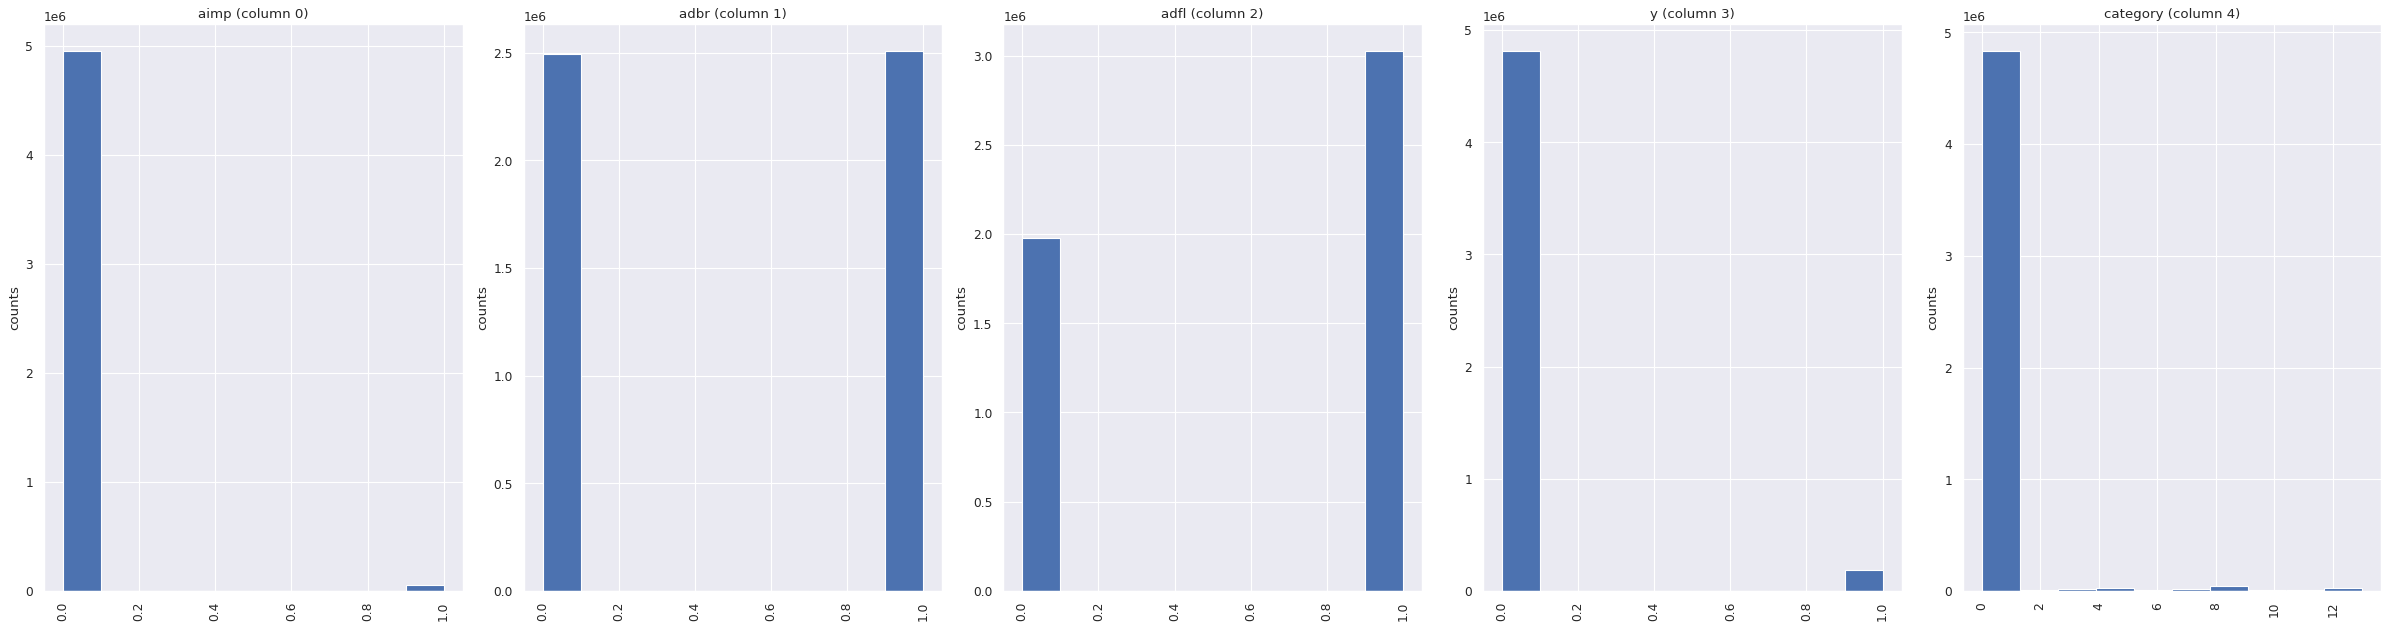

In [121]:
plotPerColumnDistribution(df, 20, 5)

In [122]:
cut_off_i = int(0.8*len(df))
train_data = df.iloc[:cut_off_i]
train_data = train_data[train_data['y'] == 0]
test_data = df.iloc[cut_off_i:]

In [123]:
y_train = train_data['y']
y_test = test_data['y']
X_train = train_data.drop(columns=['timestamp', 'y', 'category'])
X_test = test_data.drop(columns=['timestamp', 'y', 'category'])

In [124]:
print(X_train.shape)
print(X_test.shape)

(3849400, 17)
(1000000, 17)


In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
looking anomalies in the data 


In [126]:
from sklearn.decomposition import PCA

# Fit a PCA model
pca = PCA()  # Keep two principal components for easier visualization
X_pca = pca.fit_transform(X_train_scaled)

# Explained variance ratio (to understand the variance captured by each component)
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")

Explained variance by components: [1.89254454e-01 1.79632766e-01 1.20334451e-01 9.29852381e-02
 9.02627650e-02 6.38886747e-02 6.25977530e-02 5.89063685e-02
 4.59609261e-02 4.28542907e-02 2.67138241e-02 1.40254938e-02
 8.23214408e-03 3.56643394e-03 6.65772799e-04 7.87957033e-05
 3.98487998e-05]


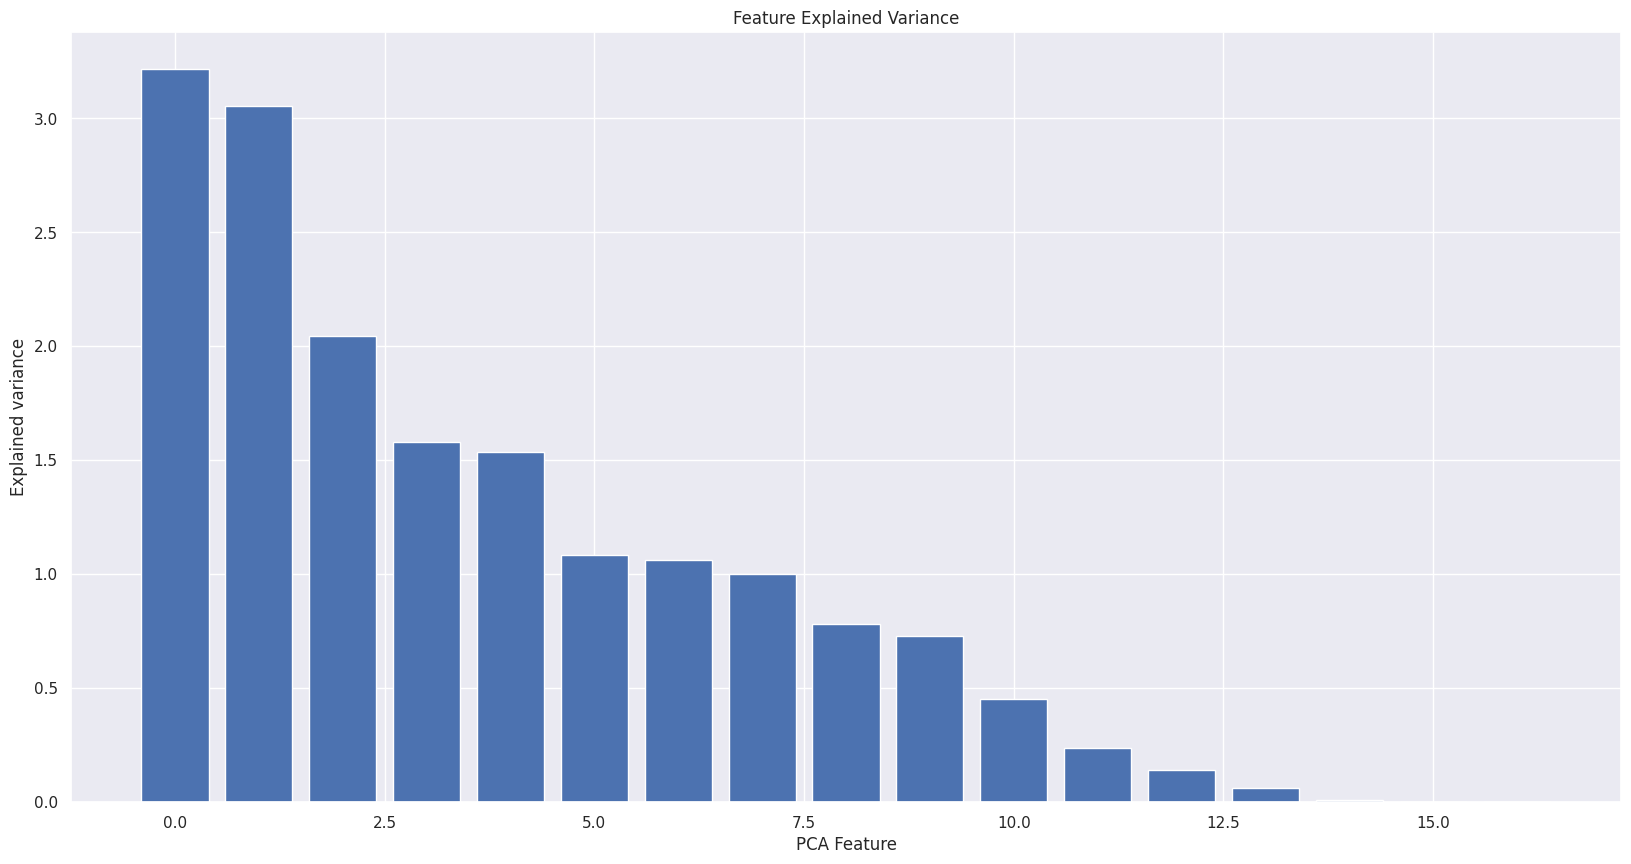

In [127]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})

# Bar plot of explained_variance
plt.bar(
    range(len(pca.explained_variance_)),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [128]:
from sklearn.decomposition import PCA

# Fit a PCA model
pca = PCA(n_components=9)  # Keep two principal components for easier visualization
X_pca = pca.fit_transform(X_train_scaled)

# Explained variance ratio (to understand the variance captured by each component)
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")

Explained variance by components: [0.18925445 0.17963277 0.12033445 0.09298524 0.09026277 0.06388867
 0.06259775 0.05890637 0.04596093]


In [129]:
print(np.cumsum(explained_variance))

[0.18925445 0.36888722 0.48922167 0.58220691 0.67246967 0.73635835
 0.7989561  0.85786247 0.9038234 ]


In [130]:
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(X_pca.shape[1])])


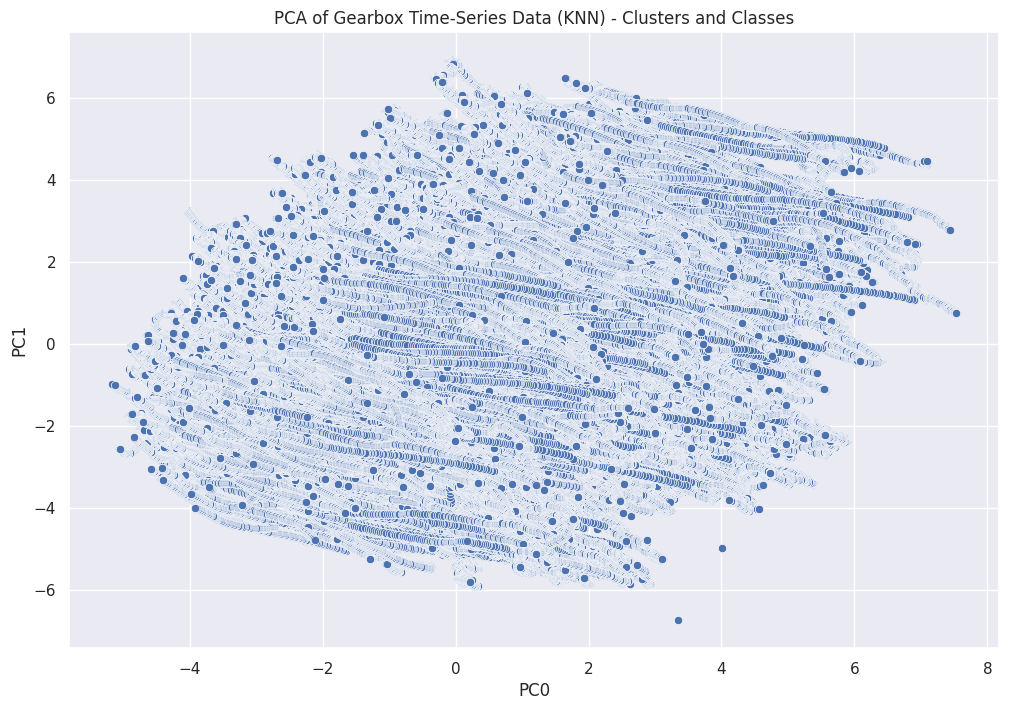

In [131]:
N=2
for i in range(N):
    for j in range(i+1,N):


        # Step 3: Plot PCA Results with Cluster and Class Indication
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x=f'PC{i}', y=f'PC{j}') #, hue='Class', style='Class', palette="Set1", markers=True)
        plt.title('PCA of Gearbox Time-Series Data (KNN) - Clusters and Classes')
        plt.show()

In [132]:
# Project the data back to the original space
X_reconstructed = pca.inverse_transform(X_pca) 

# Calculate reconstruction error (difference between original and reconstructed data)
reconstruction_error = np.mean(np.abs(X_train_scaled - X_reconstructed), axis=1)

# Add reconstruction error to the dataframe
train_data['reconstruction_error'] = reconstruction_error

# Set a threshold for anomaly detection (e.g., 95th percentile of the error)
threshold = np.percentile(reconstruction_error, 99)


In [133]:
print(threshold)

0.5200604866388131


In [134]:
X_pca_test = pca.transform(X_test_scaled)

# Project the data back to the original space
X_reconstructed = pca.inverse_transform(X_pca_test) 

# Calculate reconstruction error (difference between original and reconstructed data)
reconstruction_error = np.mean(np.abs(X_test_scaled - X_reconstructed), axis=1)

# Add reconstruction error to the dataframe
test_data['reconstruction_error'] = reconstruction_error

test_data['anomaly'] = (reconstruction_error > threshold).astype(int)

/tmp/ipykernel_30/1822507617.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_30/1822507617.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
print(y_test.value_counts())
print(test_data['anomaly'].value_counts())

y
0.0    960500
1.0     39500
Name: count, dtype: int64
anomaly
0    981064
1     18936
Name: count, dtype: int64


In [136]:
import plotly.subplots as sp
import plotly.graph_objects as go

def plot_time_series(training_data):
    # List of columns to plot (excluding the anomaly column)
    non_plot_features = ['timestamp', 'anomaly']
    columns_to_plot = [col for col in training_data.columns if col not in non_plot_features]
    
    # Create subplots
    num_cols = len(columns_to_plot)
    fig = sp.make_subplots(rows=num_cols, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=columns_to_plot)

    # Iterate through each column and add to the figure
    for i, col in enumerate(columns_to_plot):
        fig.add_trace(go.Scatter(
            x=training_data['timestamp'],  # X-axis is datetime
            y=training_data[col],  # Y-axis is the current feature
            mode='markers',
            marker=dict(
                color=training_data['anomaly'],  # Color by 'anomaly' flag
                colorscale=[[0, 'blue'], [1, 'red']],  # Blue for normal, Red for anomaly
                cmin=0,  # Set the minimum value for the color scale
                cmax=1,  # Set the maximum value for the color scale
                showscale=False  # Disable individual color scale for each subplot
            ),
            name=col  # Legend name
        ), row=i + 1, col=1)  # Place in the corresponding row

    # Update layout
    fig.update_layout(
        title='Time Series Data with Anomaly Detection',
        xaxis_title='Datetime',
        height=300 * num_cols,  # Adjust height based on the number of columns
        showlegend=False
    )

    # Show the figure
    fig.show()

# Example usage
#plot_time_series(test_data.iloc[::100])


Accuracy: 96.05%


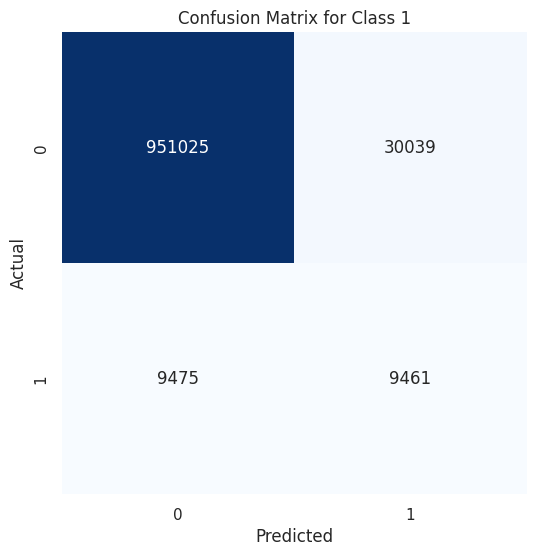

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98    981064
     Anomaly       0.24      0.50      0.32     18936

    accuracy                           0.96   1000000
   macro avg       0.61      0.73      0.65   1000000
weighted avg       0.98      0.96      0.97   1000000



In [137]:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Evaluate the classifier
accuracy = accuracy_score(test_data['anomaly'], y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


cm = confusion_matrix(test_data['anomaly'], y_test)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f'Confusion Matrix for Class {i}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
report = classification_report(test_data['anomaly'], y_test, target_names=['Normal', 'Anomaly'])
print(report)